# Imports

## Packages

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Data

In [4]:
file_path="../raw_data/"
print(os.listdir(file_path))

['application_test.csv', '.DS_Store', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', 'previous_application.csv', 'bureau_balance.csv']


In [5]:
app_train = pd.read_csv(os.path.join(file_path,'application_train.csv')) 
pos_cash_balance = pd.read_csv(os.path.join(file_path,'POS_CASH_balance.csv')) 
credit_card_balance = pd.read_csv(os.path.join(file_path,'credit_card_balance.csv')) 
installments_payments = pd.read_csv(os.path.join(file_path,'installments_payments.csv'))
bureau = pd.read_csv(os.path.join(file_path,'bureau.csv'))
previous_application = pd.read_csv(os.path.join(file_path,'previous_application.csv')) 
bureau_balance = pd.read_csv(os.path.join(file_path,'bureau_balance.csv'))
app_test = pd.read_csv(os.path.join(file_path,'application_test.csv'))

In [6]:
credit_card_balance.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF'], dtype='object')

In [7]:
test = credit_card_balance[['AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL','AMT_RECEIVABLE_PRINCIPAL',
                            'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
                            'AMT_RECIVABLE','AMT_TOTAL_RECEIVABLE','SK_ID_PREV', 'SK_ID_CURR']]
test = test.dropna()

In [8]:
# check if total receivables = total balance
test['rec_bal_diff'] = test['AMT_BALANCE'] - test['AMT_TOTAL_RECEIVABLE']

In [9]:
test['rec_bal_diff'].agg('sum') 

658303708.5450003

In [10]:
# check if can back-engineer interest rate
test['int_rec'] = test['AMT_TOTAL_RECEIVABLE'] - test['AMT_RECEIVABLE_PRINCIPAL']
test['int_rate'] = test['int_rec']/test['AMT_RECEIVABLE_PRINCIPAL']
test.head()

,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_RECEIVABLE_PRINCIPAL,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,SK_ID_PREV,SK_ID_CURR,rec_bal_diff,int_rec,int_rate
0,56.970,135000,0.000,1700.325,1800.0,1800.0,0.000,0.000,2562384,378907,56.97,0.000,NaN
1,63975.555,45000,60175.080,2250.000,2250.0,2250.0,64875.555,64875.555,2582071,363914,-900.00,4700.475,0.078113
2,31815.225,450000,26926.425,2250.000,2250.0,2250.0,31460.085,31460.085,1740877,371185,355.14,4533.660,0.168372
3,236572.110,225000,224949.285,11795.760,11925.0,11925.0,233048.970,233048.970,1389973,337855,3523.14,8099.685,0.036007
4,453919.455,450000,443044.395,22924.890,27000.0,27000.0,453919.455,453919.455,1891521,126868,0.00,10875.060,0.024546


In [11]:
test['test_pmt'] = (test['int_rate']) * test['AMT_BALANCE']
test['test_pmt_diff'] = test['test_pmt'] - test['AMT_PAYMENT_CURRENT']
test['test_pmt_diff'].agg('sum')

nan

In [12]:
test.head(20)

,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_RECEIVABLE_PRINCIPAL,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,SK_ID_PREV,SK_ID_CURR,rec_bal_diff,int_rec,int_rate,test_pmt,test_pmt_diff
0,56.970,135000,0.000,1700.325,1800.000,1800.000,0.000,0.000,2562384,378907,56.970,0.000,NaN,NaN,NaN
1,63975.555,45000,60175.080,2250.000,2250.000,2250.000,64875.555,64875.555,2582071,363914,-900.000,4700.475,0.078113,4997.342702,2747.342702
2,31815.225,450000,26926.425,2250.000,2250.000,2250.000,31460.085,31460.085,1740877,371185,355.140,4533.660,0.168372,5356.797754,3106.797754
3,236572.110,225000,224949.285,11795.760,11925.000,11925.000,233048.970,233048.970,1389973,337855,3523.140,8099.685,0.036007,8518.184758,-3406.815242
4,453919.455,450000,443044.395,22924.890,27000.000,27000.000,453919.455,453919.455,1891521,126868,0.000,10875.060,0.024546,11142.001488,-15857.998512
5,82903.815,270000,80519.040,4449.105,3825.000,3825.000,82773.315,82773.315,2646502,380010,130.500,2254.275,0.027997,2321.041055,-1503.958945
6,353451.645,585000,345433.860,14684.175,15750.000,15750.000,351881.145,351881.145,1079071,171320,1570.500,6447.285,0.018664,6596.931433,-9153.068567
7,47962.125,45000,44735.310,0.000,264.690,0.000,47962.125,47962.125,2095912,118650,0.000,3226.815,0.072131,3459.569284,3194.879284
8,291543.075,292500,285376.410,130.500,4093.515,4093.515,286831.575,286831.575,2181852,367360,4711.500,1455.165,0.005099,1486.609488,-2606.905512
9,201261.195,225000,192793.275,6338.340,45000.000,45000.000,197224.695,197224.695,1235299,203885,4036.500,4431.420,0.022985,4626.058065,-40373.941935


# Profile Reports

In [13]:
from pandas_profiling import ProfileReport

In [14]:
profile = ProfileReport(app_train, title='application_train',minimal=True,explorative=True)
profile.to_file("app_train.html")

Summarize dataset:   0%|          | 0/130 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
profile = ProfileReport(pos_cash_balance, title='pos_cash_balance',minimal=True,explorative=True)
profile.to_file("pos_cash_balance.html")

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
profile = ProfileReport(credit_card_balance, title='credit_card_balance',minimal=True,explorative=True)
profile.to_file("credit_card_balance.html")

Summarize dataset:   0%|          | 0/31 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
profile = ProfileReport(installments_payments, title='installments_payments',minimal=True,explorative=True)
profile.to_file("installments_payments.html")

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [19]:
profile = ProfileReport(bureau, title='bureau',minimal=True,explorative=True)
profile.to_file("bureau.html")

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
profile = ProfileReport(previous_application, title='previous_application',minimal=True,explorative=True)
profile.to_file("previous_application.html")

Summarize dataset:   0%|          | 0/45 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
profile = ProfileReport(bureau_balance, title='bureau_balance',minimal=True,explorative=True)
profile.to_file("bureau_balance.html")

Summarize dataset:   0%|          | 0/11 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
profile = ProfileReport(app_test, title='app_test',minimal=True,explorative=True)
profile.to_file("app_test.html")

Summarize dataset:   0%|          | 0/129 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# EDA

## Target value counts

In [23]:
app_train.TARGET.value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

## Missing values

There are 307511 rows and 122 columns


,0
COMMONAREA_MEDI,69.872297
COMMONAREA_AVG,69.872297
COMMONAREA_MODE,69.872297
NONLIVINGAPARTMENTS_MODE,69.432963
NONLIVINGAPARTMENTS_AVG,69.432963
NONLIVINGAPARTMENTS_MEDI,69.432963
FONDKAPREMONT_MODE,68.386172
LIVINGAPARTMENTS_MODE,68.354953
LIVINGAPARTMENTS_AVG,68.354953
LIVINGAPARTMENTS_MEDI,68.354953


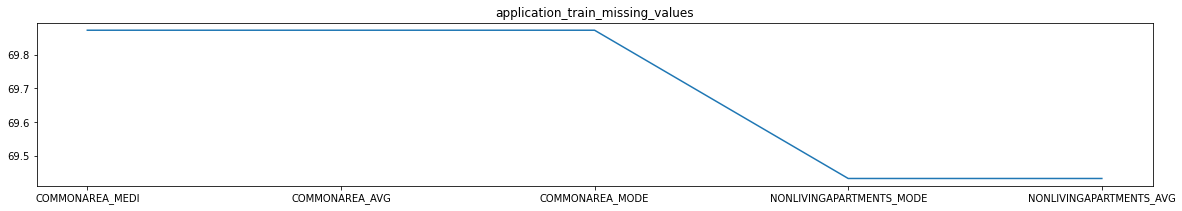

In [24]:
percent = (app_train.isnull().sum()/len(app_train)*100).sort_values(ascending = False)
app_train_missing = pd.DataFrame(percent)
shape = app_train.shape
print(f'There are {shape[0]} rows and {shape[1]} columns')
plt.subplots(figsize=(20,3))
plt.title("application_train_missing_values")
plt.plot(app_train_missing.head())
app_train_missing.head(10)

There are 48744 rows and 121 columns


,0
COMMONAREA_AVG,68.716150
COMMONAREA_MODE,68.716150
COMMONAREA_MEDI,68.716150
NONLIVINGAPARTMENTS_AVG,68.412523
NONLIVINGAPARTMENTS_MODE,68.412523
NONLIVINGAPARTMENTS_MEDI,68.412523
FONDKAPREMONT_MODE,67.284179
LIVINGAPARTMENTS_AVG,67.249302
LIVINGAPARTMENTS_MODE,67.249302
LIVINGAPARTMENTS_MEDI,67.249302


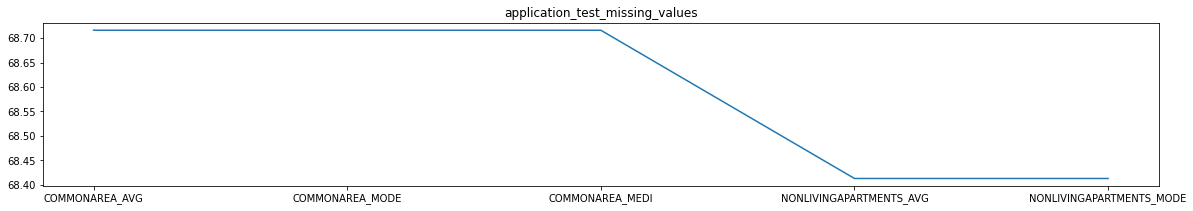

In [25]:
percent = (app_test.isnull().sum()/len(app_test)*100).sort_values(ascending = False)
app_test_missing = pd.DataFrame(percent)
shape = app_test.shape
print(f'There are {shape[0]} rows and {shape[1]} columns')
plt.subplots(figsize=(20,3))
plt.title("application_test_missing_values")
plt.plot(app_test_missing.head())
app_test_missing.head(20)

There are 10001358 rows and 8 columns


,0
CNT_INSTALMENT_FUTURE,0.260835
CNT_INSTALMENT,0.260675
SK_ID_PREV,0.000000
SK_ID_CURR,0.000000
MONTHS_BALANCE,0.000000
NAME_CONTRACT_STATUS,0.000000
SK_DPD,0.000000
SK_DPD_DEF,0.000000


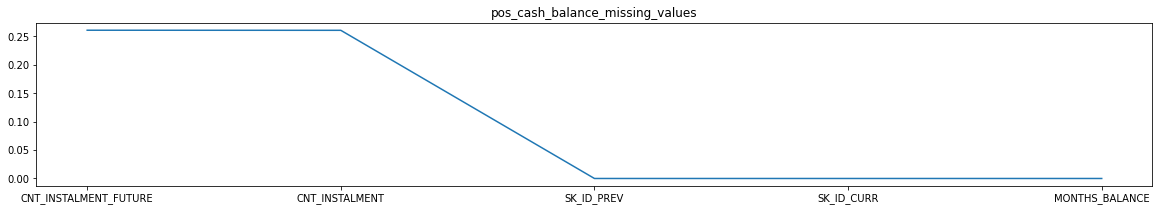

In [26]:
percent = (pos_cash_balance.isnull().sum()/len(pos_cash_balance)*100).sort_values(ascending = False)
pos_cash_balance_missing = pd.DataFrame(percent)
shape = pos_cash_balance.shape
print(f'There are {shape[0]} rows and {shape[1]} columns')
plt.subplots(figsize=(20,3))
plt.title("pos_cash_balance_missing_values")
plt.plot(pos_cash_balance_missing.head())
pos_cash_balance_missing.head(20)

There are 3840312 rows and 23 columns


,0
AMT_PAYMENT_CURRENT,19.998063
AMT_DRAWINGS_ATM_CURRENT,19.524872
CNT_DRAWINGS_POS_CURRENT,19.524872
AMT_DRAWINGS_OTHER_CURRENT,19.524872
AMT_DRAWINGS_POS_CURRENT,19.524872
CNT_DRAWINGS_OTHER_CURRENT,19.524872
CNT_DRAWINGS_ATM_CURRENT,19.524872
CNT_INSTALMENT_MATURE_CUM,7.948208
AMT_INST_MIN_REGULARITY,7.948208
SK_ID_PREV,0.000000


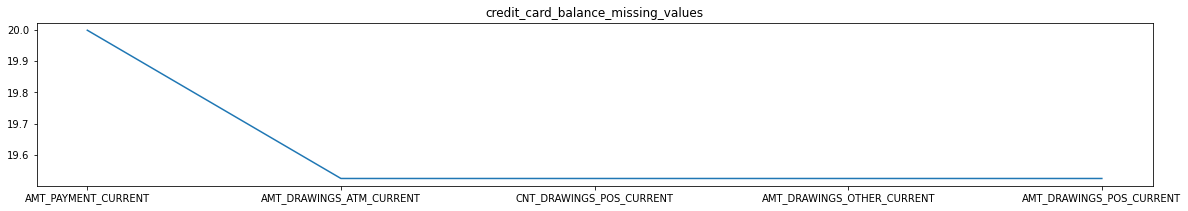

In [27]:
percent = (credit_card_balance.isnull().sum()/len(credit_card_balance)*100).sort_values(ascending = False)
credit_card_balance_missing = pd.DataFrame(percent)
shape = credit_card_balance.shape
print(f'There are {shape[0]} rows and {shape[1]} columns')
plt.subplots(figsize=(20,3))
plt.title("credit_card_balance_missing_values")
plt.plot(credit_card_balance_missing.head())
credit_card_balance_missing.head(10)

There are 13605401 rows and 8 columns


,0
DAYS_ENTRY_PAYMENT,0.021352
AMT_PAYMENT,0.021352
SK_ID_PREV,0.000000
SK_ID_CURR,0.000000
NUM_INSTALMENT_VERSION,0.000000


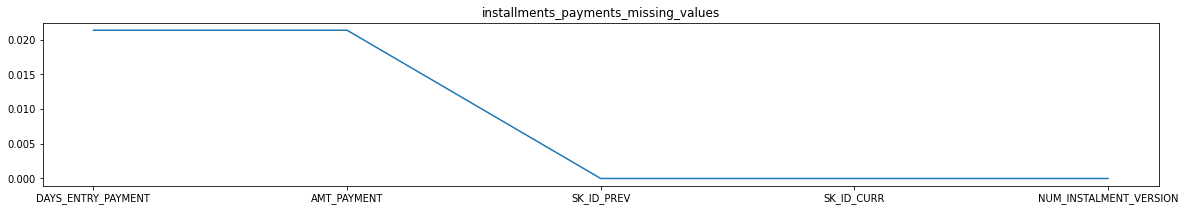

In [28]:
percent = (installments_payments.isnull().sum()/len(installments_payments)*100).sort_values(ascending = False)
installments_payments_missing = pd.DataFrame(percent)
shape = installments_payments.shape
print(f'There are {shape[0]} rows and {shape[1]} columns')
plt.subplots(figsize=(20,3))
plt.title("installments_payments_missing_values")
plt.plot(installments_payments_missing.head())
installments_payments_missing.head(5)

There are 1716428 rows and 17 columns


,0
AMT_ANNUITY,71.473490
AMT_CREDIT_MAX_OVERDUE,65.513264
DAYS_ENDDATE_FACT,36.916958
AMT_CREDIT_SUM_LIMIT,34.477415
AMT_CREDIT_SUM_DEBT,15.011932
DAYS_CREDIT_ENDDATE,6.149573
AMT_CREDIT_SUM,0.000757
CREDIT_ACTIVE,0.000000
CREDIT_CURRENCY,0.000000
DAYS_CREDIT,0.000000


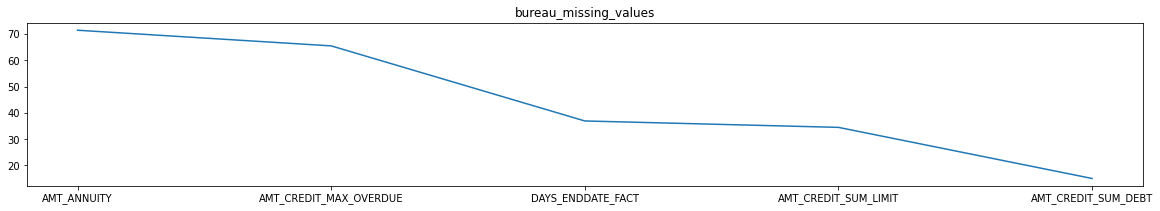

In [29]:
percent = (bureau.isnull().sum()/len(bureau)*100).sort_values(ascending = False)
bureau_missing = pd.DataFrame(percent)
shape = bureau.shape
print(f'There are {shape[0]} rows and {shape[1]} columns')
plt.subplots(figsize=(20,3))
plt.title("bureau_missing_values")
plt.plot(bureau_missing.head())
bureau_missing.head(10)

There are 1670214 rows and 37 columns


,0
RATE_INTEREST_PRIVILEGED,99.643698
RATE_INTEREST_PRIMARY,99.643698
AMT_DOWN_PAYMENT,53.636480
RATE_DOWN_PAYMENT,53.636480
NAME_TYPE_SUITE,49.119754
NFLAG_INSURED_ON_APPROVAL,40.298129
DAYS_TERMINATION,40.298129
DAYS_LAST_DUE,40.298129
DAYS_LAST_DUE_1ST_VERSION,40.298129
DAYS_FIRST_DUE,40.298129


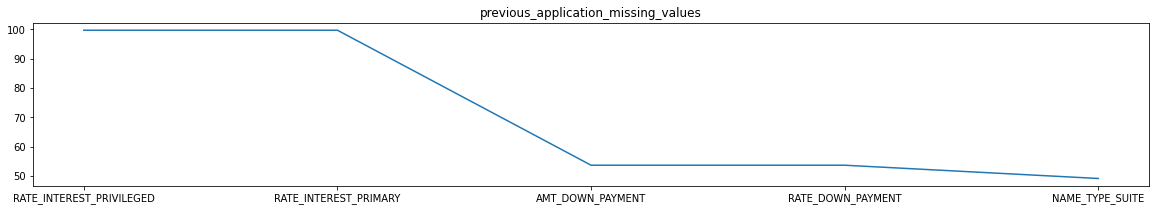

In [30]:
percent = (previous_application.isnull().sum()/len(previous_application)*100).sort_values(ascending = False)
previous_application_missing = pd.DataFrame(percent)
shape = previous_application.shape
print(f'There are {shape[0]} rows and {shape[1]} columns')
plt.subplots(figsize=(20,3))
plt.title("previous_application_missing_values")
plt.plot(previous_application_missing.head())
previous_application_missing.head(10)

There are 27299925 rows and 3 columns


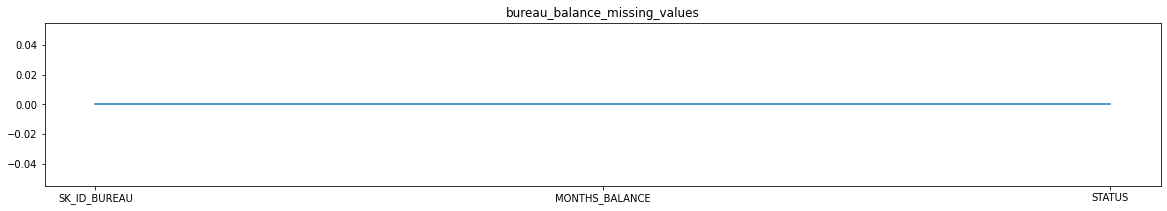

In [31]:
percent = (bureau_balance.isnull().sum()/len(bureau_balance)*100).sort_values(ascending = False)
bureau_balance_missing = pd.DataFrame(percent)
shape = bureau_balance.shape
print(f'There are {shape[0]} rows and {shape[1]} columns')
plt.subplots(figsize=(20,3))
plt.title("bureau_balance_missing_values")
plt.plot(bureau_balance_missing.head())

## Correlation

<AxesSubplot:>

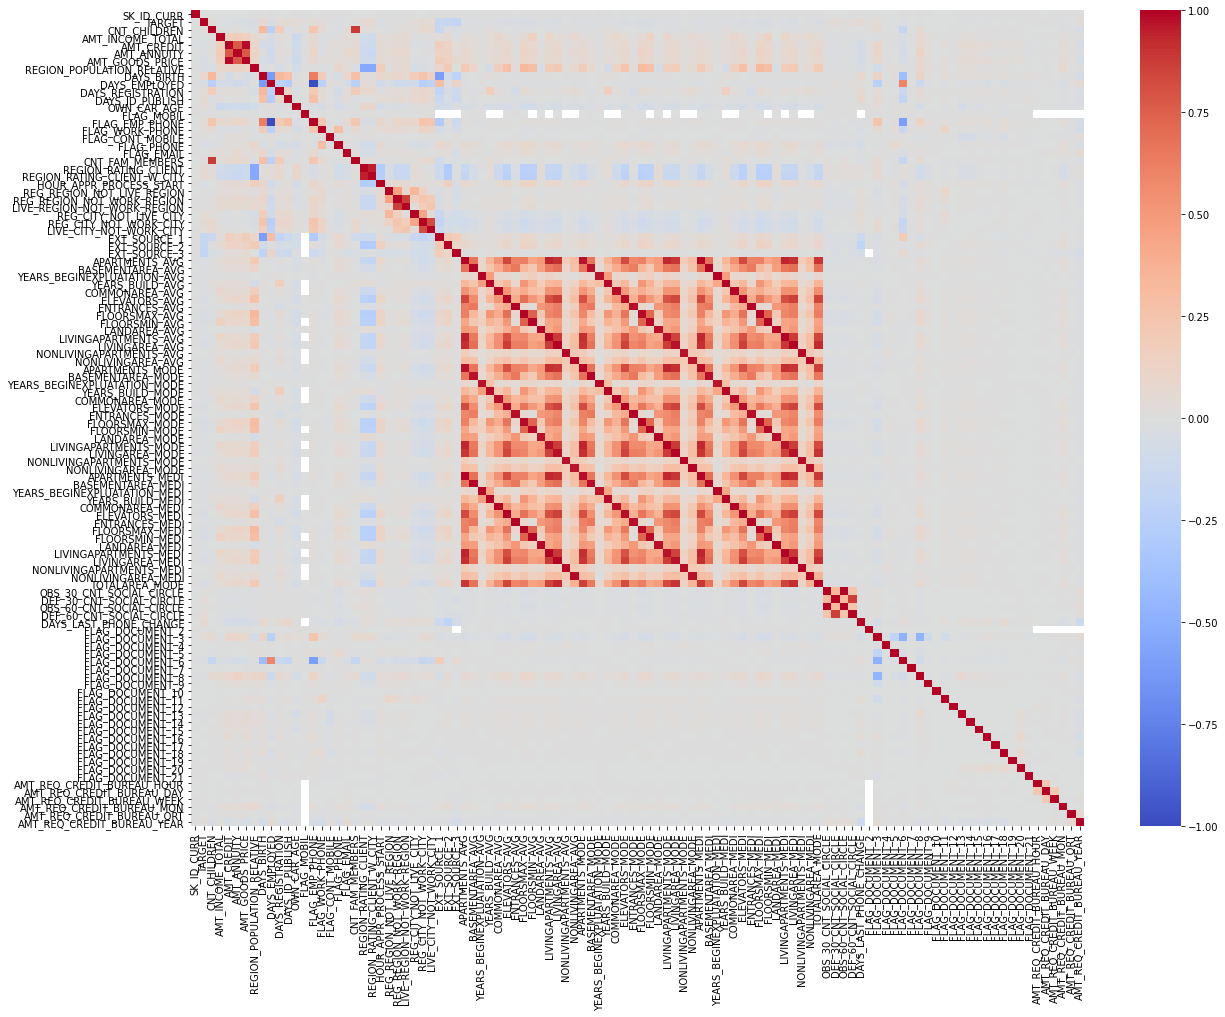

In [32]:
corr = app_train.corr()

# plot the heatmap
plt.subplots(figsize=(20,15))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

In [33]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df = corr_df.drop_duplicates(subset=['correlation'])
corr_df.head()

,feature_1,feature_2,correlation
6713,YEARS_BUILD_MEDI,YEARS_BUILD_AVG,0.998495
8237,OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,0.998490
4308,FLOORSMIN_AVG,FLOORSMIN_MEDI,0.997241
7141,FLOORSMAX_MEDI,FLOORSMAX_AVG,0.997034
7034,ENTRANCES_MEDI,ENTRANCES_AVG,0.996886


In [34]:
list(app_train.columns)

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

In [35]:
living_columns = 'SK_ID_CURR','APARTMENTS_AVG','BASEMENTAREA_AVG','YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG',
'COMMONAREA_AVG','ELEVATORS_AVG','ENTRANCES_AVG','FLOORSMAX_AVG','FLOORSMIN_AVG','LANDAREA_AVG','LIVINGAPARTMENTS_AVG',
'LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG','NONLIVINGAREA_AVG','APARTMENTS_MODE','BASEMENTAREA_MODE',
'YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE','COMMONAREA_MODE','ELEVATORS_MODE','ENTRANCES_MODE',
'FLOORSMAX_MODE','FLOORSMIN_MODE','LANDAREA_MODE','LIVINGAPARTMENTS_MODE','LIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE',
'NONLIVINGAREA_MODE','APARTMENTS_MEDI','BASEMENTAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI','YEARS_BUILD_MEDI',
'COMMONAREA_MEDI','ELEVATORS_MEDI','ENTRANCES_MEDI','FLOORSMAX_MEDI','FLOORSMIN_MEDI','LANDAREA_MEDI',
'LIVINGAPARTMENTS_MEDI','LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAREA_MEDI','FONDKAPREMONT_MODE',
'HOUSETYPE_MODE','TOTALAREA_MODE','WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE'

('HOUSETYPE_MODE',
 'TOTALAREA_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE')

In [36]:
df_living = app_train[['SK_ID_CURR','APARTMENTS_AVG','BASEMENTAREA_AVG','YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG',
'COMMONAREA_AVG','ELEVATORS_AVG','ENTRANCES_AVG','FLOORSMAX_AVG','FLOORSMIN_AVG','LANDAREA_AVG','LIVINGAPARTMENTS_AVG',
'LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG','NONLIVINGAREA_AVG','APARTMENTS_MODE','BASEMENTAREA_MODE',
'YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE','COMMONAREA_MODE','ELEVATORS_MODE','ENTRANCES_MODE',
'FLOORSMAX_MODE','FLOORSMIN_MODE','LANDAREA_MODE','LIVINGAPARTMENTS_MODE','LIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE',
'NONLIVINGAREA_MODE','APARTMENTS_MEDI','BASEMENTAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI','YEARS_BUILD_MEDI',
'COMMONAREA_MEDI','ELEVATORS_MEDI','ENTRANCES_MEDI','FLOORSMAX_MEDI','FLOORSMIN_MEDI','LANDAREA_MEDI',
'LIVINGAPARTMENTS_MEDI','LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAREA_MEDI','FONDKAPREMONT_MODE',
'HOUSETYPE_MODE','TOTALAREA_MODE','WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE']]

In [37]:
app_train_slim = app_train.drop(columns=['OWN_CAR_AGE','APARTMENTS_AVG','BASEMENTAREA_AVG',
'YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG',
'COMMONAREA_AVG','ELEVATORS_AVG','ENTRANCES_AVG','FLOORSMAX_AVG','FLOORSMIN_AVG','LANDAREA_AVG','LIVINGAPARTMENTS_AVG',
'LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG','NONLIVINGAREA_AVG','APARTMENTS_MODE','BASEMENTAREA_MODE',
'YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE','COMMONAREA_MODE','ELEVATORS_MODE','ENTRANCES_MODE',
'FLOORSMAX_MODE','FLOORSMIN_MODE','LANDAREA_MODE','LIVINGAPARTMENTS_MODE','LIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE',
'NONLIVINGAREA_MODE','APARTMENTS_MEDI','BASEMENTAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI','YEARS_BUILD_MEDI',
'COMMONAREA_MEDI','ELEVATORS_MEDI','ENTRANCES_MEDI','FLOORSMAX_MEDI','FLOORSMIN_MEDI','LANDAREA_MEDI',
'LIVINGAPARTMENTS_MEDI','LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAREA_MEDI','FONDKAPREMONT_MODE',
'HOUSETYPE_MODE','TOTALAREA_MODE','WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE'])

<AxesSubplot:>

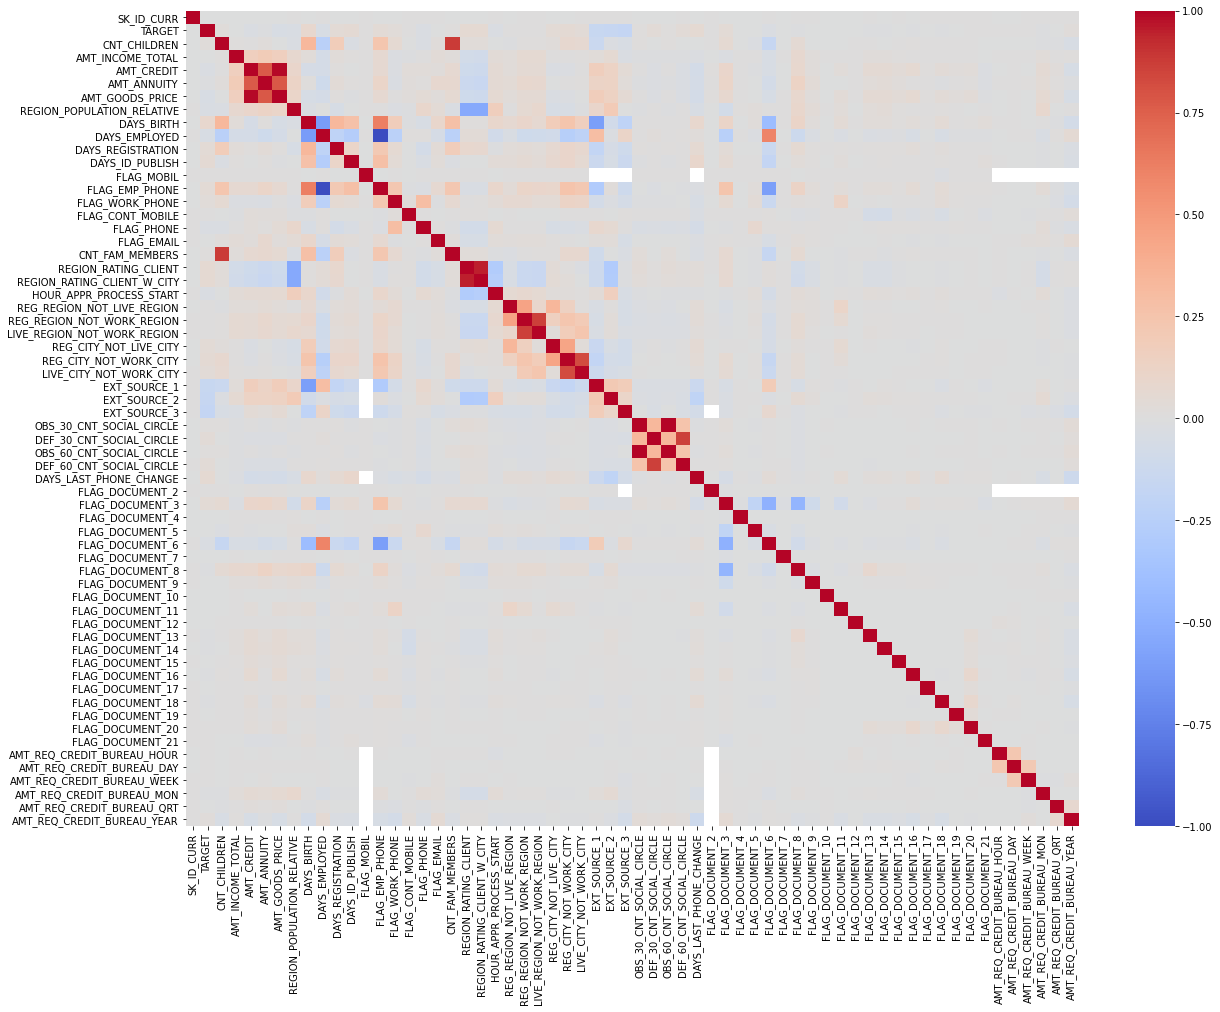

In [38]:
corr = app_train_slim.corr()

# plot the heatmap
plt.subplots(figsize=(20,15))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

In [39]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df = corr_df.drop_duplicates(subset=['correlation'])
corr_df.head()

,feature_1,feature_2,correlation
1955,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,0.998490
254,AMT_CREDIT,AMT_GOODS_PRICE,0.986968
1259,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,0.950842
1118,CNT_FAM_MEMBERS,CNT_CHILDREN,0.879161
1450,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,0.860627


In [40]:
# df_living.isnull().sum().sort_values(ascending=False)/len(df_living) #NaN percentage for each column
# app_train_dtypes = pd.DataFrame(app_train_slim.dtypes)
# app_train_dtypes.value_counts()

In [41]:
app_train_slim.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,1.422245,0.143421,1.405292,0.100049,-962.858788,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910682,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.211062,1.910602e-01,0.194844,2.400989,0.446698,2.379803,0.362291,826.808487,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014568,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,-4299.000000,1.000000,1.000

In [42]:
app_train_slim.isnull().sum().sort_values(ascending=False)/len(app_train_slim) #NaN percentage for each column

EXT_SOURCE_1                   0.563811
OCCUPATION_TYPE                0.313455
EXT_SOURCE_3                   0.198253
AMT_REQ_CREDIT_BUREAU_YEAR     0.135016
AMT_REQ_CREDIT_BUREAU_QRT      0.135016
AMT_REQ_CREDIT_BUREAU_MON      0.135016
AMT_REQ_CREDIT_BUREAU_WEEK     0.135016
AMT_REQ_CREDIT_BUREAU_DAY      0.135016
AMT_REQ_CREDIT_BUREAU_HOUR     0.135016
NAME_TYPE_SUITE                0.004201
OBS_30_CNT_SOCIAL_CIRCLE       0.003320
DEF_30_CNT_SOCIAL_CIRCLE       0.003320
OBS_60_CNT_SOCIAL_CIRCLE       0.003320
DEF_60_CNT_SOCIAL_CIRCLE       0.003320
EXT_SOURCE_2                   0.002146
AMT_GOODS_PRICE                0.000904
AMT_ANNUITY                    0.000039
CNT_FAM_MEMBERS                0.000007
DAYS_LAST_PHONE_CHANGE         0.000003
FLAG_DOCUMENT_16               0.000000
FLAG_DOCUMENT_15               0.000000
FLAG_DOCUMENT_21               0.000000
FLAG_DOCUMENT_20               0.000000
FLAG_DOCUMENT_19               0.000000
FLAG_DOCUMENT_2                0.000000


# Monday's work

In [43]:
# Thursday pm - Friday
# box plots
# further eda
# cool function that allows select dtypes

In [44]:
app_train.shape

(307511, 122)

<AxesSubplot:ylabel='Frequency'>

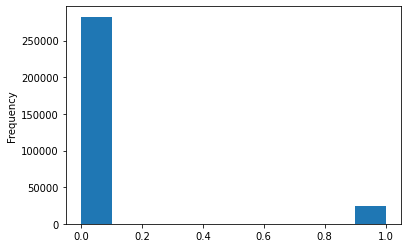

In [45]:
app_train['TARGET'].astype(int).plot.hist()

In [46]:
names = [app_train,bureau,bureau_balance,pos_cash_balance,
         credit_card_balance,previous_application,installments_payments]
features = 0
for n in names: 
    shape = n.shape[1]
    features += shape
print(f'There are {features-4} features in the entire dataset')

There are 214 features in the entire dataset


In [47]:
def dtypes(df,dfname):
    a=pd.DataFrame(df.dtypes.value_counts())
    a.rename( columns={0 : dfname}, inplace=True )
    return a

In [48]:
app_train_dtypes=dtypes(app_train,'app_train')
bureau_dtypes=dtypes(bureau,'bureau')
bureau_balance_dtypes=dtypes(bureau_balance,'bureau_balance')
pos_cash_balance_dtypes=dtypes(pos_cash_balance,'pos_cash_balance')
credit_card_balance_dtypes=dtypes(credit_card_balance,'credit_card_balance')
previous_application_dtypes=dtypes(previous_application,'previous_application')
installments_payments_dtypes=dtypes(installments_payments,'installments_payments')

In [49]:
dtypes = pd.concat([app_train_dtypes,bureau_dtypes,bureau_balance_dtypes,pos_cash_balance_dtypes,
                    credit_card_balance_dtypes,previous_application_dtypes,installments_payments_dtypes],axis=1)
dtypes

,app_train,bureau,bureau_balance,pos_cash_balance,credit_card_balance,previous_application,installments_payments
float64,65,8,NaN,2,15,15,5.0
int64,41,6,2.0,5,7,6,3.0
object,16,3,1.0,1,1,16,NaN


In [50]:
cols = list(app_train.select_dtypes([np.int64,np.float64]).columns)[2:]
cols

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXP

In [51]:
app_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

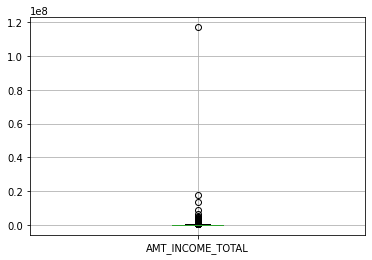

In [52]:
boxplot = app_train.boxplot(column=['AMT_INCOME_TOTAL'])

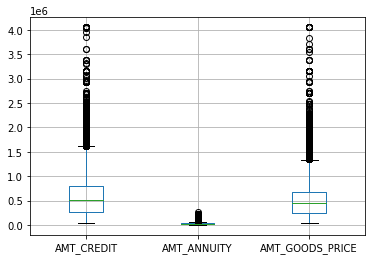

In [53]:
boxplot = app_train.boxplot(column=['AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE'])

<AxesSubplot:>

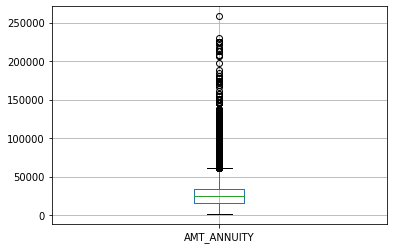

In [54]:
app_train.boxplot(column=['AMT_ANNUITY'])

<AxesSubplot:>

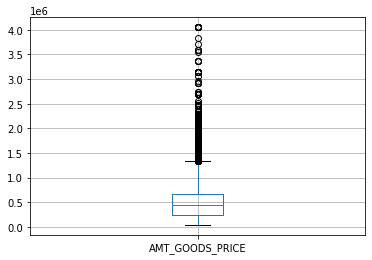

In [55]:
app_train.boxplot(column=['AMT_GOODS_PRICE'])

<AxesSubplot:>

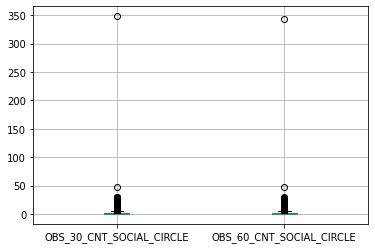

In [56]:
app_train.boxplot(column=['OBS_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE'])

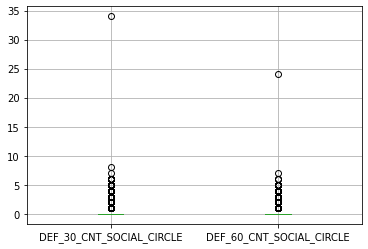

In [57]:
boxplot = app_train.boxplot(column=['DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE'])

# Merge datasets

## bureau and bureau_balance

In [58]:
bureau_merged = bureau.merge(bureau_balance,on='SK_ID_BUREAU')

## How many unique rows does each df have?

In [59]:
names = ['app_train','app_test','bureau_merged','pos_cash_balance',
         'credit_card_balance','previous_application','installments_payments']
shape = [app_train.shape[0],app_test.shape[0],bureau_merged.shape[0],pos_cash_balance.shape[0],
         credit_card_balance.shape[0],previous_application.shape[0],installments_payments.shape[0]]
unique = [app_train.groupby('SK_ID_CURR').count().shape[0],app_test.groupby('SK_ID_CURR').count().shape[0],
          bureau_merged.groupby('SK_ID_CURR').count().shape[0],
          pos_cash_balance.groupby('SK_ID_CURR').count().shape[0],
         credit_card_balance.groupby('SK_ID_CURR').count().shape[0],
          previous_application.groupby('SK_ID_CURR').count().shape[0],
          installments_payments.groupby('SK_ID_CURR').count().shape[0]]

pd.DataFrame(list(zip(names,shape,unique)),
               columns =['df_name', 'rows', 'unique_rows'])

,df_name,rows,unique_rows
0,app_train,307511,307511
1,app_test,48744,48744
2,bureau_merged,24179741,134542
3,pos_cash_balance,10001358,337252
4,credit_card_balance,3840312,103558
5,previous_application,1670214,338857
6,installments_payments,13605401,339587


In [60]:
bureau_merged.groupby('SK_ID_CURR').agg(['count','mean','max','min','std'])

SK_ID_BUREAU                                                DAYS_CREDIT                                      CREDIT_DAY_OVERDUE                   DAYS_CREDIT_ENDDATE                                            DAYS_ENDDATE_FACT                                          AMT_CREDIT_MAX_OVERDUE                                                CNT_CREDIT_PROLONG                             AMT_CREDIT_SUM                                                      AMT_CREDIT_SUM_DEBT                                                AMT_CREDIT_SUM_LIMIT                                             AMT_CREDIT_SUM_OVERDUE                     DAYS_CREDIT_UPDATE                                     AMT_ANNUITY                                                    MONTHS_BALANCE                              
                  count          mean      max      min            std       count         mean   max   min         std              count mean max min  std               count         mean      max     min          std             count         mean     max     min         std                  count          mean        max      min          std              count      mean max min       std          count           mean         max        min            std               count           mean         max  min            std                count          mean        max  min           std                  count mean  max  min  std              count         mean  max   min         std       count           mean       max        min            std          count       mean max min        std
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
100001              172  5.896632e+06  5896636  5896630       1.626317         172 -1009.284884   -49 -1572  410.783882                172  0.0   0   0  0.0                 172  -456.029070   1778.0 -1329.0   746.754870               140  -908.421429  -544.0 -1328.0  346.604435                      0           NaN        NaN      NaN          NaN                172  0.000000   0   0  0.000000            172  161516.250000   378000.00   85500.00   97178.968378                 172   23893.770349   373239.00  0.0   57099.698512                  161      0.000000      0.000  0.0      0.000000                    172  0.0  0.0  0.0  0.0                172  -127.651163   -6  -155   57.383855         172    1236.244186   10822.5      0.000    2802.888030            172 -16.279070   0 -51  12.430533
100002              110  6.152350e+06  6158909  6113835   15962.618780         110  -996.781818  -103 -1437  329.106809                110  0.0   0   0  0.0                  90  -452.800000    780.0 -1072.0   724.698670                90  -808.400000   -36.0 -1185.0  419.170202                     56   1312.010357   5043.645      0.0  1818.230162                110  0.000000   0   0  0.000000            110  111388.838727   450000.00       0.00  146658.503357                  56   70223.142857   245781.00  0.0  112037.377771                   40   3198.856500  31988.565  0.0   9718.823722                    110  0.0  0.0  0.0  0.0                110  -631.963636   -7 -1185  475.155598          94       0.000000       0.0      0.000       0.000000            110 -24.554545   0 -47  11.104662
1

# Bureau functions I

In [61]:
def get_bureau_processed(bureau):
    bureau['BUREAU_ENDDATE_FACT_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']
  
    bureau['BUREAU_CREDIT_DEBT_RATIO']=bureau['AMT_CREDIT_SUM_DEBT']/bureau['AMT_CREDIT_SUM']
    #bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM_DEBT'] - bureau['AMT_CREDIT_SUM']
    
    bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x >120 else 0)
    
    return bureau

In [62]:
def get_bureau_day_amt_agg(bureau):
    bureau_agg_dict = {
    'SK_ID_BUREAU':['count'],
    'DAYS_CREDIT':['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean', 'sum'],

    'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
    'BUREAU_IS_DPD':['mean', 'sum'],
    'BUREAU_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_grp = bureau.groupby('SK_ID_CURR')
    bureau_day_amt_agg = bureau_grp.agg(bureau_agg_dict)
    bureau_day_amt_agg.columns = ['BUREAU_'+('_').join(column).upper() for column in bureau_day_amt_agg.columns.ravel()]
    # SK_ID_CURR reset_index()
    bureau_day_amt_agg = bureau_day_amt_agg.reset_index()
    #print('bureau_day_amt_agg shape:', bureau_day_amt_agg.shape)
    return bureau_day_amt_agg

In [63]:
def get_bureau_active_agg(bureau):
    '''
    Bureau CREDIT_ACTIVE='Active' filtering
    SK_ID_CURR aggregation
    '''
    # CREDIT_ACTIVE='Active' filtering
    cond_active = bureau['CREDIT_ACTIVE'] == 'Active'
    bureau_active_grp = bureau[cond_active].groupby(['SK_ID_CURR'])
    bureau_agg_dict = {
      'SK_ID_BUREAU':['count'],
      'DAYS_CREDIT':['min', 'max', 'mean'],
      'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
      'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
      'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
      'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
      'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
      'AMT_ANNUITY': ['max', 'mean', 'sum'],

      'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
      'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
      'BUREAU_IS_DPD':['mean', 'sum'],
      'BUREAU_IS_DPD_OVER120':['mean', 'sum']
      }

    bureau_active_agg = bureau_active_grp.agg(bureau_agg_dict)
    bureau_active_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_active_agg.columns.ravel()]
    # SK_ID_CURR reset_index() 
    bureau_active_agg = bureau_active_agg.reset_index()
    #print('bureau_active_agg shape:', bureau_active_agg.shape)
    return bureau_active_agg

# BUREAU DAYS_CREDIT -750
get_bureau_active_agg(bureau)

KeyError: "Column 'BUREAU_ENDDATE_FACT_DIFF' does not exist!"

In [ ]:
def get_bureau_days750_agg(bureau):
    cond_days750 = bureau['DAYS_CREDIT'] > -750
    bureau_days750_group = bureau[cond_days750].groupby('SK_ID_CURR')
    bureau_agg_dict = {
        'SK_ID_BUREAU':['count'],
        'DAYS_CREDIT':['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
        'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
        'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean', 'sum'],
        
        'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
        'BUREAU_IS_DPD':['mean', 'sum'],
        'BUREAU_IS_DPD_OVER120':['mean', 'sum']
        }

    bureau_days750_agg = bureau_days750_group.agg(bureau_agg_dict)
    bureau_days750_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_days750_agg.columns.ravel()]
    bureau_days750_agg = bureau_days750_agg.reset_index()
    
    return bureau_days750_agg

# bureau_bal SK_ID_CURR MONTHS_BALANCE aggregation

In [ ]:
def get_bureau_bal_agg(bureau, bureau_bal):
    # SK_ID_CURR Group by bureau SK_ID_CURR 
    bureau_bal = bureau_bal.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on='SK_ID_BUREAU', how='left')
    
    # STATUS 120
    bureau_bal['BUREAU_BAL_IS_DPD'] = bureau_bal['STATUS'].apply(lambda x: 1 if x in['1','2','3','4','5']  else 0)
    bureau_bal['BUREAU_BAL_IS_DPD_OVER120'] = bureau_bal['STATUS'].apply(lambda x: 1 if x =='5'  else 0)
    bureau_bal_grp = bureau_bal.groupby('SK_ID_CURR')
    # SK_ID_CURR MONTHS_BALANCE aggregation
    bureau_bal_agg_dict = {
        'SK_ID_CURR':['count'],
        'MONTHS_BALANCE':['min', 'max', 'mean'],
        'BUREAU_BAL_IS_DPD':['mean', 'sum'],
        'BUREAU_BAL_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_bal_agg = bureau_bal_grp.agg(bureau_bal_agg_dict)
    bureau_bal_agg.columns = [ 'BUREAU_BAL_'+('_').join(column).upper() for column in bureau_bal_agg.columns.ravel() ]
    # SK_ID_CURR reset_index()
    bureau_bal_agg = bureau_bal_agg.reset_index()
    #print('bureau_bal_agg shape:', bureau_bal_agg.shape)
    return bureau_bal_agg

# bureau aggregation

In [ ]:
def get_bureau_agg(bureau, bureau_bal):
    
    bureau = get_bureau_processed(bureau)
    bureau_day_amt_agg = get_bureau_day_amt_agg(bureau)
    bureau_active_agg = get_bureau_active_agg(bureau)
    bureau_days750_agg = get_bureau_days750_agg(bureau)
    bureau_bal_agg = get_bureau_bal_agg(bureau, bureau_bal)
    
    # bureau_day_amt_agg bureau_active_agg
    bureau_agg = bureau_day_amt_agg.merge(bureau_active_agg, on='SK_ID_CURR', how='left')
    # STATUS ACTIVE IS_DPD RATIO
    #bureau_agg['BUREAU_IS_DPD_RATIO'] = bureau_agg['BUREAU_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    #bureau_agg['BUREAU_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    bureau_agg['BUREAU_ACT_IS_DPD_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    bureau_agg['BUREAU_ACT_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    
    # bureau_agg bureau_bal_agg
    bureau_agg = bureau_agg.merge(bureau_bal_agg, on='SK_ID_CURR', how='left')
    bureau_agg = bureau_agg.merge(bureau_days750_agg, on='SK_ID_CURR', how='left') 
    #bureau_bal_agg['BUREAU_BAL_IS_DPD_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']
    #bureau_bal_agg['BUREAU_BAL_IS_DPD_OVER120_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_OVER120_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']

    #print('bureau_agg shape:', bureau_agg.shape)
    
    return bureau_agg

In [ ]:
x = get_bureau_agg(bureau.copy(), bureau_balance)
x.head()

In [ ]:
bureau.isnull().sum().sort_values(ascending=False)/len(bureau)

# Bureau - Feature Engineering

In [ ]:
bureau = pd.read_csv(os.path.join(file_path,'bureau.csv'))

## Utilisation calculation

In [ ]:
# Utilisation calculation - put into function
# Calculate utilisation based on AMT_CREDIT_SUM_LIMIT and AMT_CREDIT_SUM
# drop AMT_CREDIT_SUM, AMT_CREDIT_SUM_DEBT, and AMT_CREDIT_SUM_LIMIT columns
bureau['total_util_limit']=bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM_LIMIT'] 
# bureau[bureau['CREDIT_ACTIVE']=='Active'].head(60)
bureau['total_util_sum']=bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM'] 
# bureau.drop(columns=['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', and 'AMT_CREDIT_SUM_LIMIT'])
bureau.shape

In [ ]:
# Test above by checking the following with diff credit types
bureau[bureau['CREDIT_TYPE']=='Mortgage']

## Calculate percent overdue
* AMT_CREDIT_SUM_OVERDUE is 99.8% zeros; recommend dropping
* AMT_CREDIT_MAX_OVERDUE IS 65.5% missing and has valuable info; nans can be filled with zero

In [ ]:
# Percent overdue calculation - put into function
# Calculate utilisation based on AMT_CREDIT_SUM_LIMIT and AMT_CREDIT_SUM
# drop AMT_CREDIT_SUM, AMT_CREDIT_SUM_OVERDUE, and AMT_CREDIT_SUM_LIMIT columns
bureau['overdue_percent_limit']=bureau['AMT_CREDIT_MAX_OVERDUE'] / bureau['AMT_CREDIT_SUM_LIMIT'] 
# bureau[bureau['CREDIT_ACTIVE']=='Active'].head(60)
bureau['overdue_percent_sum']=bureau['AMT_CREDIT_MAX_OVERDUE'] / bureau['AMT_CREDIT_SUM'] 
# bureau.drop(columns=['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_OVERDUE', and 'AMT_CREDIT_SUM_LIMIT'])
bureau.shape

In [ ]:
bureau.head(20)

## Encode Credit_Active column

In [ ]:
bureau = pd.read_csv(os.path.join(file_path,'bureau.csv'))

In [ ]:
# Encode Credit_Active Column
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

credit_act = bureau[['CREDIT_ACTIVE']]
credit_act_OHE = ohe.fit_transform(credit_act)
f = ohe.get_feature_names()
bureau[f[0]],bureau[f[1]],bureau[f[2]],bureau[f[3]]=credit_act_OHE.T

In [ ]:
# Test encoder
bureau[bureau['CREDIT_ACTIVE']=='Sold']

## Encode Credit_Type for Active Loans only 

In [ ]:
bureau_active = bureau[bureau['CREDIT_ACTIVE']=='Active']

In [ ]:
bureau['CREDIT_TYPE'].value_counts()

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# bureau['CREDIT_TYPE'] = le.fit_transform(bureau['CREDIT_TYPE'])

Question: Label Encode or OHE?

In [ ]:
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')

credit_type = bureau[['CREDIT_TYPE']]
credit_type_OHE = ohe.fit_transform(credit_type)
f = ohe.get_feature_names()
# for f in f:
#     bureau[f]=credit_type_OHE.T
bureau[f[0]],bureau[f[1]],bureau[f[2]],bureau[f[3]],bureau[f[4]],
bureau[f[5]],bureau[f[6]],bureau[f[7]],bureau[f[8]],bureau[f[9]],
bureau[f[10]],bureau[f[11]],bureau[f[12]],bureau[f[13]],bureau[f[14]]=credit_type_OHE.T

In [ ]:
ohe.get_feature_names()

In [ ]:
bureau.head()
bureau['CNT_CREDIT_PROLONG'].value_counts()

In [ ]:
bureau.isnull().sum().sort_values(ascending=False)/len(bureau)

# Bureau Functions - II

In [ ]:
# Number of Past Loans per Customer
B = bureau
grp = B[['SK_ID_CURR', 'DAYS_CREDIT']].groupby(by = ['SK_ID_CURR'])['DAYS_CREDIT'].count().reset_index().rename(index=str, columns={'DAYS_CREDIT': 'BUREAU_LOAN_COUNT'})
B = B.merge(grp, on = ['SK_ID_CURR'], how = 'left')
grp

In [ ]:
bureau.groupby('SK_ID_CURR').count()

In [ ]:
# Number of Types of Past Loans per Customer
B = bureau
grp = B[['SK_ID_CURR', 'CREDIT_TYPE']].groupby(by = ['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index().rename(index=str, columns={'CREDIT_TYPE': 'BUREAU_LOAN_TYPES'})
# B = B.merge(grp, on = ['SK_ID_CURR'], how = 'left')
# B
grp

In [ ]:
B = bureau.copy()
# Number of Loans per Customer
grp = B[['SK_ID_CURR', 'DAYS_CREDIT']].groupby(by = ['SK_ID_CURR'])['DAYS_CREDIT'].count().reset_index().rename(index=str, columns={'DAYS_CREDIT': 'BUREAU_LOAN_COUNT'})
B = B.merge(grp, on = ['SK_ID_CURR'], how = 'left')

# Number of types of Credit loans for each Customer 
grp = B[['SK_ID_CURR', 'CREDIT_TYPE']].groupby(by = ['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index().rename(index=str, columns={'CREDIT_TYPE': 'BUREAU_LOAN_TYPES'})
B = B.merge(grp, on = ['SK_ID_CURR'], how = 'left')

# Average Number of Loans per Loan Type
B['AVERAGE_LOAN_TYPE'] = B['BUREAU_LOAN_COUNT']/B['BUREAU_LOAN_TYPES']
# del B['BUREAU_LOAN_COUNT'], B['BUREAU_LOAN_TYPES']
B

In [ ]:
bureau.head()